In [212]:
from collections import Counter

import numpy as np
import pandas as pd

import sklearn
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau



from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline


out_dict = dict()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
df = pd.read_csv( # Считываем исходный набор данных, разделитель - символ табуляции, заголовок отсутствует
    'https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv',
    delimiter='\t',
    header=None
)
df.head(5) # Посмотрим на первые 5 строк в считанном наборе данных


,0,1
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


In [7]:
! pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.6/284.6 kB 27.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# __________start of block__________

texts_train = df[0].values[:5000] # В качестве обучающей выборки выбираем первые 5000 предложений
y_train = df[1].values[:5000] # Каждому предложению соответствует некоторая метка класса - целое число
texts_test = df[0].values[5000:] # В качестве тестовой выборки используем все оставшиеся предложения
y_test = df[1].values[5000:]

from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer() # В качестве токенов будем использовать отдельные слова и знаки препинания

# В качестве предобработки будем приводить текст к нижнему регистру.
# Предобработанный текст будем представлять в виде выделенных токенов, разделённых пробелом
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),) # Посмотрим, как работает предобработка для заданной строки text

texts_train = [preprocess(text) for text in texts_train] # Получаем предобработанное представление для тренировочной выборки
texts_test = [preprocess(text) for text in texts_test] # Аналогично получаем предобработанное представление для тестовой выборки

# Выполняем небольшие проверки того, насколько корректно были обработаны тренировочная и тестовая выборки
assert texts_train[5] ==  'campanella gets the tone just right funny in the middle of sad in the middle of hopeful'
assert texts_test[74] == 'poetry in motion captured on film'
assert len(texts_test) == len(y_test)

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown - up at work : replace " i don ' t want to do that " with " ok , great !".


In [200]:
#  __________start of block__________
def plot_train_process(train_loss, val_loss, train_accuracy, val_accuracy, title_suffix=''):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title(' '.join(['Loss', title_suffix]))
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title(' '.join(['Validation accuracy', title_suffix]))
    axes[1].plot(train_accuracy, label='train')
    axes[1].plot(val_accuracy, label='validation')
    axes[1].legend()
    plt.show()

def visualize_and_save_results(model, model_name, X_train, X_test, y_train, y_test, out_dict):
    for data_name, X, y, model in [
    ('train', X_train, y_train, model),
    ('test', X_test, y_test, model)
    ]:
        if isinstance(model, BaseEstimator):
            proba = model.predict_proba(X)[:, 1]
        elif isinstance(model, nn.Module):
            proba = model(X).detach().cpu().numpy()[:, 1]
        else:
            raise ValueError('Unrecognized model type')

        auc = roc_auc_score(y, proba)

        out_dict['{}_{}'.format(model_name, data_name)] = auc
        plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (data_name, auc))

    plt.plot([0, 1], [0, 1], '--', color='black',)
    plt.legend(fontsize='large')
    plt.title(model_name)
    plt.grid()
    return out_dict
# __________end of block__________

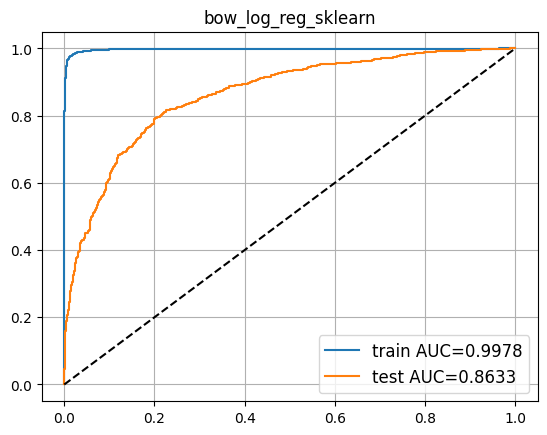

In [201]:
k = min(10000, len(set(' '.join(texts_train).split()))) # Если в словаре меньше 10000 слов, то берём все слова, в противном случае выберем 10000 самых популярных

# Построим словарь всех уникальных слов в обучающей выборке,
# оставив только k наиболее популярных слов.

counts = Counter(' '.join(texts_train).split())
bow_vocabulary = [key for key, val in counts.most_common(k)]


def text_to_bow(text):
    """ Функция, позволяющая превратить входную строку в векторное представление на основании модели мешка слов. """
    sent_vec = np.zeros(len(bow_vocabulary))
    counts = Counter(text.split())
    for i, token in enumerate(bow_vocabulary):
        if token in counts:
            sent_vec[i] = counts[token]
    return np.array(sent_vec, 'float32')

X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

# Небольшие проверки - они нужны, если Вы захотите реализовать собственную модель мешка слов.
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[65, bow_vocabulary.index('!')] == texts_train[65].split().count('!')


# Строим модель логистической регрессии для полученных векторных представлений текстов
bow_model = LogisticRegression(max_iter=1500).fit(X_train_bow, y_train)

out_dict = visualize_and_save_results(bow_model, 'bow_log_reg_sklearn', X_train_bow, X_test_bow, y_train, y_test, out_dict)
# __________end of block__________

In [19]:
len(X_train_bow[1])

10000

In [203]:
class NN(nn.Module):
    def __init__(self, input):
        super().__init__()
        self.Linein = nn.Linear(in_features=input, out_features=2)
    def forward(self,x):
        x = self.Linein(x)
        nn.Softmax(x)
        return x

In [204]:
model = NN(input= 10000)

In [205]:
# функция потерь
loss_function = torch.nn.CrossEntropyLoss()

# оптимизатор
learning_rate = 1e-3
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [206]:
X_train_bow_torch = torch.Tensor(X_train_bow)
X_test_bow_torch = torch.Tensor(X_test_bow)

y_train_torch = torch.LongTensor(y_train)
y_test_torch = torch.LongTensor((y_test))# your code here

In [266]:
def train_model(
    model,
    opt,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    n_iterations=500,
    batch_size=32,
    show_plots=True,
    eval_every=50
):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in range(n_iterations):

        # Получаем случайный батч размера batch_size для проведения обучения
        ix = np.random.randint(0, X_train_torch.shape[0], batch_size)
        x_batch = X_train_torch[ix]
        y_batch = y_train_torch[ix]

        # Предсказываем отклик (log-probabilities или logits)
        y_predicted = model(x_batch) # your code here

        # Вычисляем loss, как и выше
        loss =loss_function(y_predicted,y_batch) # your code here

        # clear gradients
        opt.zero_grad()# your code here
        # Вычисляем градиенты
        loss.backward()# your code here
        # Adam step
        opt.step()# your code here

        

        local_train_loss_history.append(loss.item())
        local_train_acc_history.append(
            accuracy_score(
                y_batch.to('cpu').detach().numpy(),
                y_predicted.to('cpu').detach().numpy().argmax(axis=1)
            )
        )

        if i % eval_every == 0:
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            predictions_val = model(X_val_torch)
            val_loss_history.append(loss_function(predictions_val, y_val_torch).to('cpu').detach().item())

            acc_score_val = accuracy_score(y_val_torch.cpu().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis=1))
            val_acc_history.append(acc_score_val)

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    return model

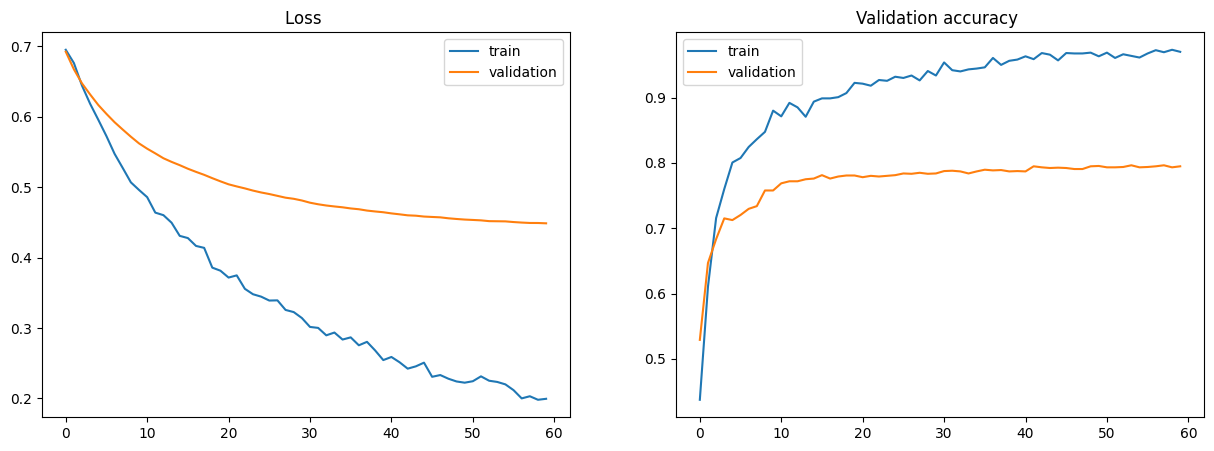

In [208]:
bow_nn_model = train_model(model, opt, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch, n_iterations=3000)

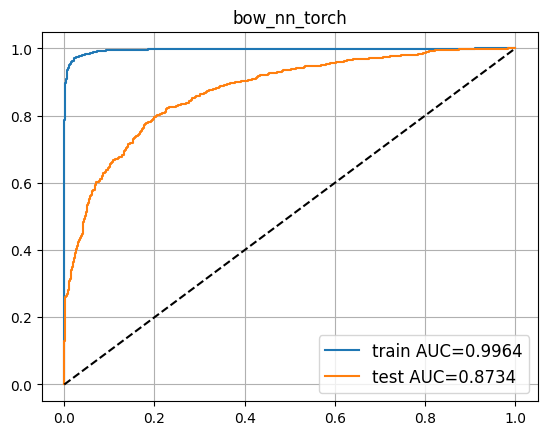

In [209]:
# Не изменяйте блок кода ниже!
# __________start of block__________
out_dict = visualize_and_save_results(bow_nn_model, 'bow_nn_torch', X_train_bow_torch, X_test_bow_torch, y_train, y_test, out_dict)

assert out_dict['bow_log_reg_sklearn_test'] - out_dict['bow_nn_torch_test'] < 0.01, 'AUC ROC on test data should be close to the sklearn implementation'
# __________end of block__________

In [178]:
out_dict

{'bow_log_reg_sklearn_train': 0.9977685523449276,
 'bow_log_reg_sklearn_test': 0.8632912603519866,
 'bow_nn_torch_train': 0.9962015217956861,
 'bow_nn_torch_test': 0.8735723038083133}

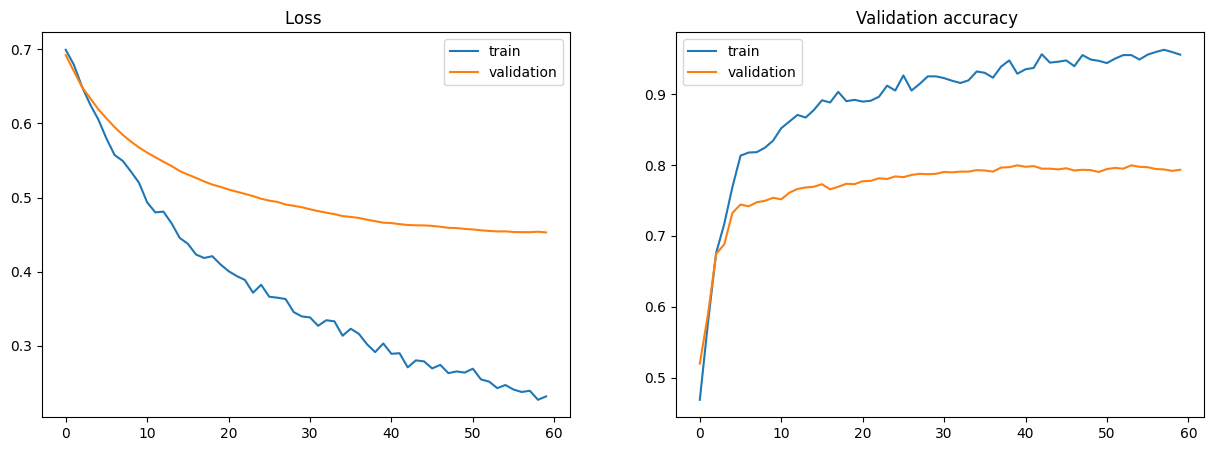

In [183]:
vocab_sizes_list = np.arange(100, 5800, 700)
results = []

for k in vocab_sizes_list:

    counts = Counter(' '.join(texts_train).split())
    bow_vocabulary = [key for key, val in counts.most_common(k)]
    X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
    X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

    
    X_train_bow_torch = torch.Tensor(X_train_bow)
    X_test_bow_torch = torch.Tensor(X_test_bow)

    y_train_torch = torch.LongTensor(y_train)
    y_test_torch = torch.LongTensor((y_test))# your code here


    model = NN(input= k)

    # функция потерь
    loss_function = torch.nn.CrossEntropyLoss()

    # оптимизатор
    learning_rate = 1e-3
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

    bow_nn_model = train_model(model, opt, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch, n_iterations=3000)

    

    predicted_probas_on_test_for_k_sized_dict = model(X_test_bow_torch).detach().cpu().numpy()[:, 1]
    assert predicted_probas_on_test_for_k_sized_dict is not None
    auc = roc_auc_score(y_test, predicted_probas_on_test_for_k_sized_dict)
    results.append(auc)

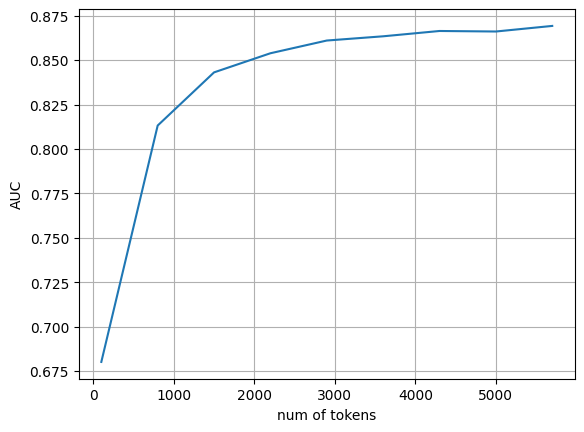

In [186]:
# Не меняйте блок кода ниже!

# __________start of block__________
assert len(results) == len(vocab_sizes_list), 'Check the code above'
assert min(results) >= 0.65, 'Seems like the model is not trained well enough'
assert results[-1] > 0.84, 'Best AUC ROC should not be lower than 0.84'

plt.plot(vocab_sizes_list, results)
plt.xlabel('num of tokens')
plt.ylabel('AUC')
plt.grid()

out_dict['bow_k_vary'] = results
# __________end of block__________

In [241]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_features=10000)

In [269]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



X_train_tfidf  = vectorizer.fit_transform(texts_train)
X_test_tfidf  = vectorizer.transform(texts_test)

X_train_tfidf_dense = X_train_tfidf.toarray()  # Convert sparse matrix to dense array
X_test_tfidf_dense = X_test_tfidf.toarray()    # Convert sparse matrix to dense array

X_train_tfidf_torch = torch.tensor(X_train_tfidf_dense).float()  # Create PyTorch tensor
X_test_tfidf_torch = torch.tensor(X_test_tfidf_dense).float()   # Create PyTorch tensor


# X_train_tfidf_torch  = torch.Tensor(X_train_tfidf)
# X_test_tfidf_torch  = torch.Tensor(X_test_tfidf)



In [274]:
model = NN(10000)

In [275]:
# функция потерь
loss_function = torch.nn.CrossEntropyLoss()

# оптимизатор
learning_rate = 1e-3
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

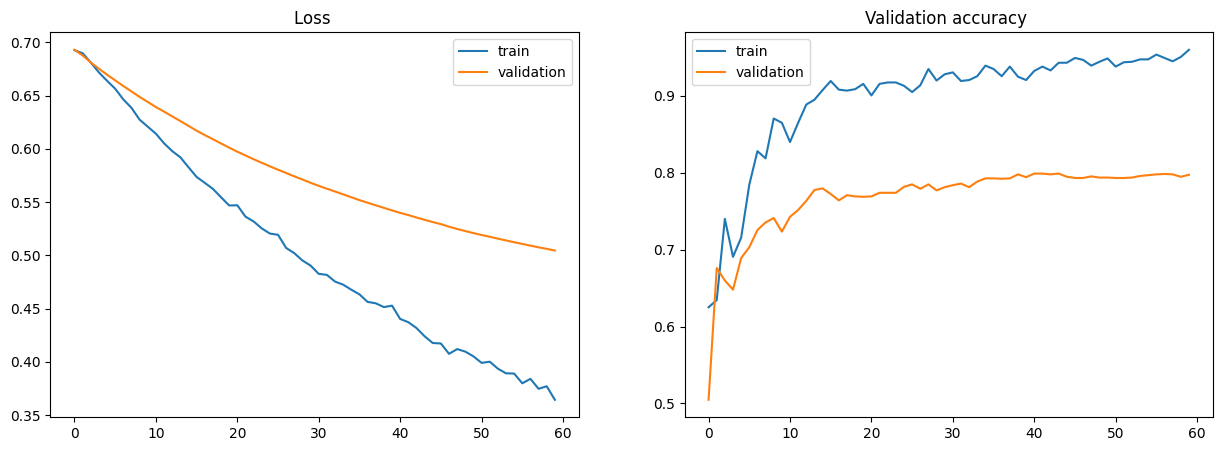

In [276]:
model_tf_idf = train_model(model, opt, X_train_tfidf_torch, y_train_torch, X_test_tfidf_torch, y_test_torch, n_iterations=3000)

In [277]:
# Не меняйте блок кода ниже!

# __________start of block__________

np.save('submission_dict_hw06.npy', out_dict, allow_pickle=True)
print('File saved to `submission_dict_hw06.npy`')
# __________end of block__________

File saved to `submission_dict_hw06.npy`
